# Introduction to pySHTOOLS

*pyshtools* is a Python module that provides functions for working with spherical harmonics. These routines can be used to perform spherical harmonic transforms and reconstructions, rotations of data expressed in spherical harmonics, and multitaper spectral analyses on the sphere. The base functions are fast routines written in Fortran 95 from the SHTOOLS package. *pyshtools* provides easy access to these routines by use of Python-wrapper functions and a compact class interface.

To get started, import the standard *matplotlib* library for graphics, *numpy* for mathematical extensions to Python, and *pyshtools*:

In [1]:
%matplotlib inline
from __future__ import print_function # only necessary if using Python 2.x

import matplotlib.pyplot as plt
import numpy as np
import pyshtools

The pyshtools module contains the three classes `SHCoeffs`, `SHGrid`, and `SHWindow`, a submodule `shtools` that contains all of the Python-wrapped Fortran functions, and a series of submodules that groups these functions (`constant`,  `legendre`, `expand`, `shio`, `spectralanalysis`, `localizedspectralanalysis`, `rotate`, `gravmag`, and `other`). `SHCoeffs`, `SHGrid`, and `SHWindow` bundle the vast majority of *pyshtools* functionality. In this notebook we will demonstrate how to use the classes related to grids and coefficients.

## Grid and coefficient classes

Let's start by first creating a power spectrum that follows a power law with exponent -2, up to and including degree 100. To avoid a division by zero, we will set the degree 0 term to zero:

In [2]:
degrees = np.arange(101, dtype=float)
degrees[0] = np.inf
power = degrees**(-2)

Next, we will create a random realization of spherical harmonic coefficients whose expected power is given by the spectrum we just created:

In [3]:
clm = pyshtools.SHCoeffs.from_random(power)

This creates a new class instance of `SHCoeffs` that contains several attributes and methods. By default, *pyshtools* assumes that the coefficients are real and that they are normalized using the `'4pi'` convention exlcuding the Condon-Shortley phase factor. This is the standard normalization in Geodesy and many fields of geophysics and spectral analysis. Other normalization can be specified explicitly by specifying the optional parameter `normalization`, which can be either `'4pi'`, `'ortho'`, or `'schmidt'`. The Condon-Shortley phase can be included by setting the optional parameter `csphase` to `-1`, and if you wanted complex coefficients, you could set `kind='complex'`.

`from_random()` is just one way to create a set of spherical harmonic coefficients. The other constructor methods are `from_file()` to read the coefficients from a file using the `SHRead` routine, `from_zeros()` if you just want all the coefficients to be set to zero, and `from_array()` if you already have a numpy array of the coefficients.

Next, let's calculate the power spectrum (i.e., the power per spherical harmonic degree) and plot it. *pyshtools* provides a built in plotting function to do this, and as we will see below, the power spectrum can also be returned as a numpy array using the `spectrum()` method.

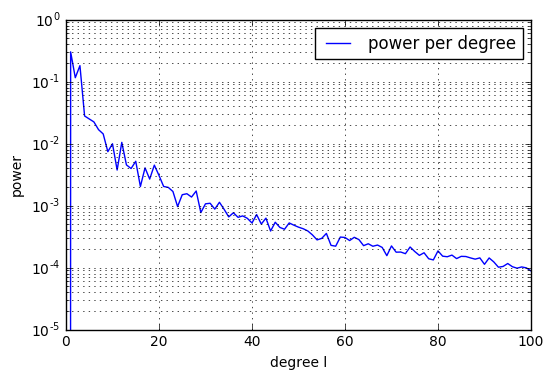

In [4]:
fig, ax = clm.plot_spectrum()

You can also visualize the power asociated with each spherical-harmonic coefficient using the `plot_spectrum2d()` method. In this example, we use the optional parameter `vrange` to scale the colormap from 1 to 1.e-7 times the maximum value.

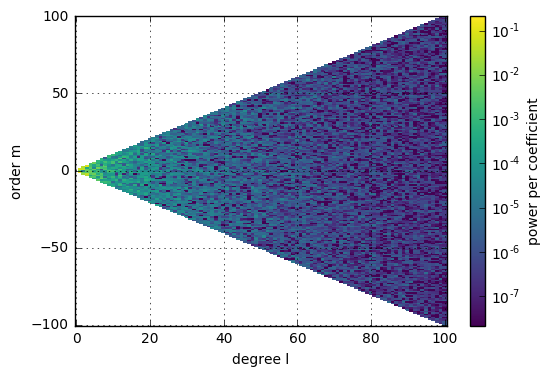

In [5]:
fig, ax = clm.plot_spectrum2d(vrange=(1.e-7,1))

The spherical harmonic coefficients of a given `SHCoeffs` class instance can be converted easily to a different normalization using the `convert()` method. Here, we will convert the coeffients to the orthonormalized convention using the Condon-Shortley phase, which is common in many fields of physics and seismology. Also, let's just return the first 50 degrees of the function:

In [6]:
clm_ortho = clm.convert(normalization='ortho', csphase=-1, lmax=50)

If you ever forget how your data are normalized, you can use the built in `info()` method to remind you:

In [7]:
clm_ortho.info()

kind = 'real'
normalization = 'ortho'
csphase = -1
lmax = 50


We will next calculate the power spectra of our two functions and plot them along with our theoretical input spectrum:

[None,

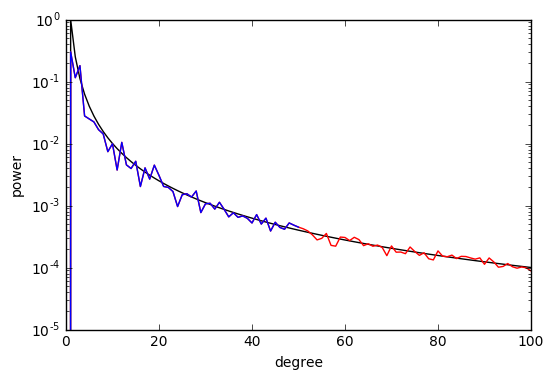

In [8]:
fix, ax = plt.subplots(1,1)
ax.plot(clm.degrees(), power, '-k', 
        clm.degrees(), clm.spectrum(), '-r', 
        clm_ortho.degrees(), clm_ortho.spectrum(), '-b')
ax.set(yscale='log', xlabel='degree', ylabel='power')

The method `degrees()` was here used to return a numpy list of the degrees from 0 up to the maximum value of the coefficients. As you can see, the power spectrum of the random realization follows closely the input spectrum. Furthermore, the power spectra are seen to be independent of the chosen normalization.

Next, let's expand the data onto a grid and plot it. We first use the `expand()` method, which returns a new instance of the class `SHGrid`, and then plot the data using the built in method `plot()`:

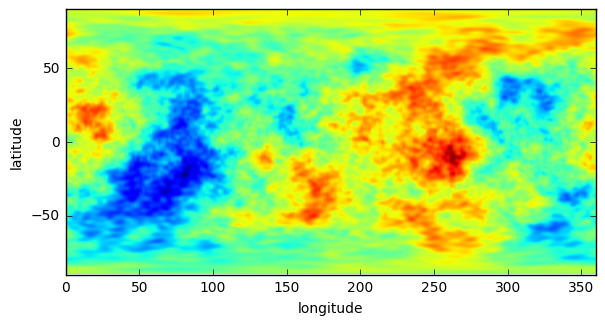

In [9]:
grid = clm.expand()
fig, ax = grid.plot()

When expanding data onto a grid, *pyshtools* provides three options. The default is to use `grid='DH'`, which is an equally-sampled grid in latitude and longitude that conforms to *Driscoll and Healy*'s (1994) sampling theorem. If you would like a grid that is oversampled in longitude by a factor or two, such that the number of longitude bands is twice that as the number of latitude bands, use `grid='DH2'` instead.

The third grid is constructed explicitly for use with Gauss-Legendre quadrature integration techniques. This grid contains about half as many latitude bands as an equivalent DH grid, but the latitudes are unequally sampled at the zeros of the Legendre polynomial of the maximum degree of the coefficients. The following commands show how to expand the spherical harmonic coefficents onto a GLQ grid, plot it, and output lists that contain the latitudes and longitudes (in degrees) for each row and column of the grid:

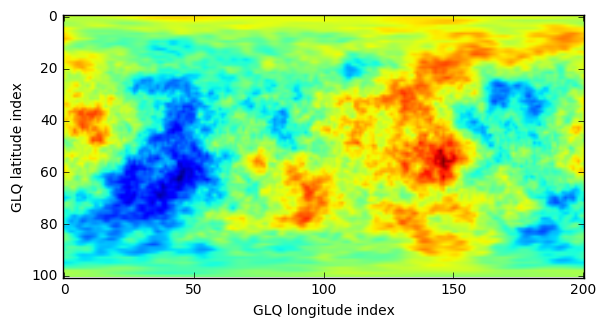

In [10]:
grid_glq = clm.expand(grid='GLQ')
grid_glq.plot()

lats = grid_glq.lats()
lons = grid_glq.lons()

Once again, if you ever forget how your grid was constructed, the `info()` method provides you with everything you need to know:

In [11]:
grid_glq.info()

kind = 'real'
grid = 'GLQ'
nlat = 101
nlon = 201
lmax = 100


In [12]:
grid.info()

kind = 'real'
grid = 'DH'
sampling = 1
nlat = 202
nlon = 202
lmax = 100


Sometimes you need to set individual spherical harmonic coefficients to a specified value. For example, for planetary topography, the degree 2 order 0 term can be atypically large as a result of the planet's rotation. Let's set this term equal to zero and replot it using an over-sampled DH grid. Though we will modify only a single coefficient here, you could also provide input arrays for `l`, `m`, and `value`. When using the `set_coeffs()` method, you set the cosine terms using positive values for the orders, and the sine terms using negative orders:

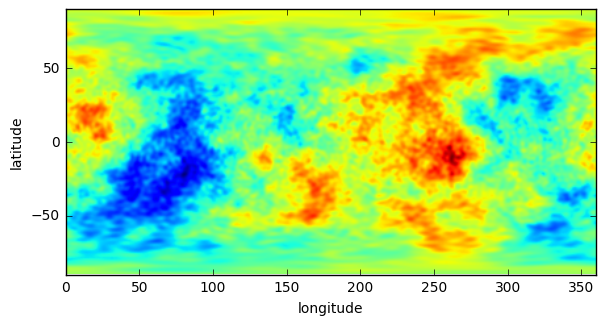

kind = 'real'
grid = 'DH'
sampling = 2
nlat = 202
nlon = 404
lmax = 100


In [13]:
l = 2
m = 0
value = 0.

clm.set_coeffs(value, l, m)
grid_dh2 = clm.expand(grid='DH2')
fig, ax = grid_dh2.plot()
grid_dh2.info()

If you want to save either the raw spherical harmonic coefficients to a file, or save the raw gridded data to a file, this can be done using the `to_file()` methods. If you want to extract the grid or coefficients as a numpy array, this can be done using the `to_array()` methods. Here, we will just extract the first few degrees of the spherical harmonic coefficients and verify that the coefficient was indeed set to zero:

In [14]:
coeffs = clm.to_array(lmax=4)
print(coeffs, end='\n\n')
print('c20 = {:f}'.format(coeffs[0,2,0]))

[[[-0.          0.          0.          0.          0.        ]
  [ 0.0932831  -0.26945443  0.          0.          0.        ]
  [ 0.          0.22964468  0.19044343  0.          0.        ]
  [ 0.06544415 -0.07170473  0.01914622  0.28231707  0.        ]
  [ 0.07240274  0.027984   -0.06079547  0.04504485  0.04172385]]

 [[ 0.          0.          0.          0.          0.        ]
  [ 0.         -0.46840626  0.          0.          0.        ]
  [ 0.          0.07694854  0.14217354  0.          0.        ]
  [ 0.         -0.05951453  0.21798192  0.19897239  0.        ]
  [ 0.         -0.08714647 -0.05982354 -0.01745727  0.053287  ]]]

c20 = 0.000000


It is also easy to rotate either the physical body or the underlying coordinate frame of the function expressed in spherical harmonics. This is accomplished using three Euler angles, `alpha`, `beta` and `gamma`. There are many different conventions for these angles, so please read the documentation before doing this blindly! Here, we will rotate the point at the north pole to 60 degrees north latitude and 180 degrees east longitude:

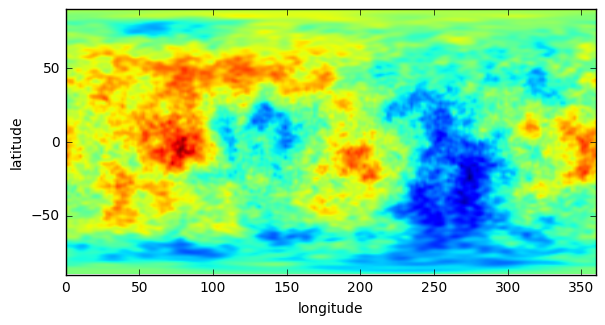

In [15]:
clat = 60.
clon = 180.

alpha = 0.
beta = -(90.-clat)
gamma = -clon

clm_rotated = clm.rotate(alpha, beta, gamma, degrees=True)
grid_rotated = clm_rotated.expand()
fig, ax = grid_rotated.plot()

By default, this routine expects the angles to be in degrees, which we specified redundantly by the provided optional parameter. If the angles were in radians, you would instead set this to `False`.

You can also perform simply arithmetic operations on `SHCoeffs` and `SHGrid` class instances. Let's create a second set of random coefficients whose power is 10 times less than our first set and expand this onto a grid.

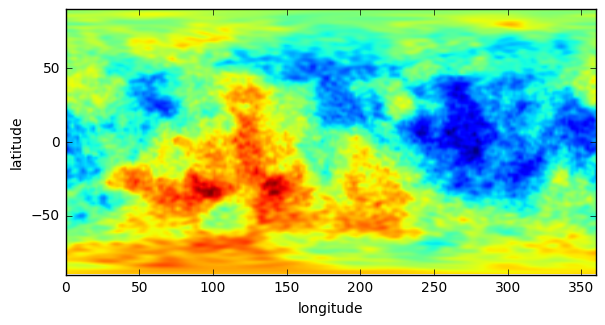

In [16]:
clm2 = pyshtools.SHCoeffs.from_random(power/10.)
grid2 = clm2.expand()
fig, ax = grid2.plot()

We can easily add, subtract multiply, and divide sets of coefficients and grids. If you need to make an exact copy of either, you can use the `copy()` method.

In [17]:
grid3 = 100 + 2*grid2 + grid**2 + grid/2 -100 - grid2*2 -grid*grid -grid/2
grid4 = grid3.copy()

Finally, *pyshtools* provides many physical constants that are useful when working with planetary data. As an example, here is the `GM` of Earth,

In [18]:
print(pyshtools.constant.gm_earth)

3.986004415e+14


along with information on it's source

In [19]:
pyshtools.constant.gm_earth.info()

Gravitational constant times the mass of the Earth.

398.6004415 10^12 m3 s-2

Reference
---------
N. K. Pavlis, S. A. Holmes, S. C. Kenyon, and J. K. Factor (2012). The
development and evaluation of the Earth Gravitational Model 2008 (EGM2008). J.
Geophys. Res. 117, B04406, doi:10.1029/2011JB008916.


All of the operations in this introduction could have also been performed using the raw Python-wrapped Fortran 95 routines. In general, when using these routines, one needs to pay attention to the specific properties of the grids and normalizations of the coefficients. The `SHCoeffs` and `SHGrid` classes simpify the access to these routines given that all the metadata is stored directly in the class attributes. Nevertheless, in some cases the wrapped SHTOOLS routines might be preferable to use as they might be more computationally efficient, or perhaps use less memory. Not all *pyshtools* routines are accessible directly from the class interfaces, and in those cases, it is often necessary to input the raw coefficients and gridded data, which can be obtained from the method `to_array()`.